## Helper functions for processing signals

In [1]:
import numpy as np

def slice_iq(iq: np.ndarray, frame_len: int = 2048, hop_len: int | None = None):
    """
    iq: 1‑D complex128 array [I + 1jQ]  
    frame_len: samples per frame  
    hop_len:   overlap; default = frame_len (no overlap)
    """
    if hop_len is None:
        hop_len = frame_len
    num_frames = 1 + (len(iq) - frame_len) // hop_len
    frames = np.lib.stride_tricks.as_strided(
        iq,
        shape=(num_frames, frame_len),
        strides=(iq.strides[0]*hop_len, iq.strides[0]),
        writeable=False,
    )
    return frames.copy()          # make it C‑contiguous


In [2]:
def rms_norm(frames: np.ndarray, eps: float = 1e-12):
    power = np.sqrt(np.mean(np.abs(frames)**2, axis=1, keepdims=True)) + eps
    return frames / power


In [3]:
from numpy.fft import fft

def log_mag_fft(frames: np.ndarray):
    # 1‑sided spectrum (N/2 bins, dropping DC & Nyquist)
    spec = fft(frames, axis=1)[:, 1:frames.shape[1]//2]
    mag  = np.abs(spec)
    return np.log1p(mag)          # log(1 + |X|)


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def preprocess(X: np.ndarray, pca_energy: float | None = 0.95):
    scaler = StandardScaler().fit(X)
    Xz = scaler.transform(X)
    if pca_energy:
        pca = PCA(n_components=pca_energy, svd_solver="full").fit(Xz)
        Xz = pca.transform(Xz)
    else:
        pca = None
    return Xz, scaler, pca


In [7]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score

def sweep_k(X, ks=(2,3,4,5,6,8,10), minibatch=True, **kmeans_kw):
    inertias, sils = [], []
    KM = KMeans
    for k in ks:
        print(f"Fitting k={k}...X shape = {X.shape}")
        km = KM(n_clusters=k, random_state=0, n_init="auto", **kmeans_kw).fit(X)
        inertias.append(km.inertia_)
        labels = km.labels_
        sils.append(silhouette_score(X, labels))
    return inertias, sils


## Loading signal data from directory
This section loads signal data from a directory and processes them to be ready for clustering

Found 6 CSV files in C:/Users/UserAdmin/Desktop/Jason - Signal Classification/AI Models/Data/synthetic/visual


Processing files:   0%|          | 0/6 [00:00<?, ?it/s]

Loading 16qam_f70M_fs56M_s10k_snr20_fadingNone_x15.csv... 

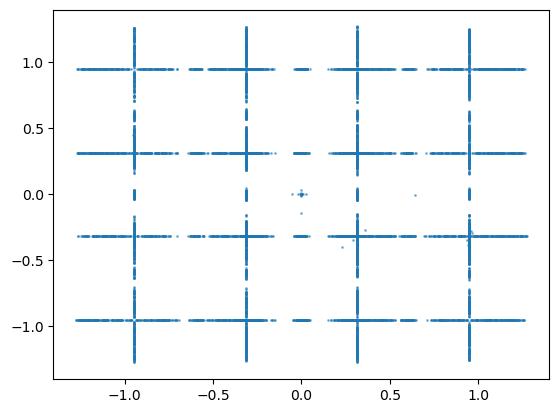

Fitting k=4...X shape = (10000, 2)
Fitting k=8...X shape = (10000, 2)
Fitting k=8...X shape = (10000, 2)
Fitting k=16...X shape = (10000, 2)
Fitting k=16...X shape = (10000, 2)
Fitting k=64...X shape = (10000, 2)
Fitting k=64...X shape = (10000, 2)


Processing files:  17%|█▋        | 1/6 [00:03<00:19,  4.00s/it]

Shape: (10000, 2)
Best k based on silhouette score: 4
Silhouette scores: {4: '0.669', 8: '0.559', 16: '0.546', 64: '0.590'}
Loading 16qam_f70M_fs56M_s10k_snr30_fadingRician_x20.csv... 

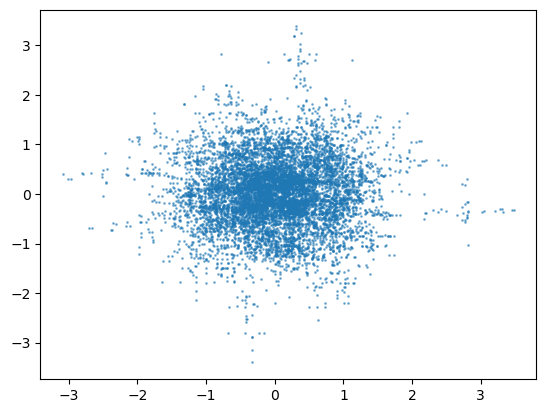

Fitting k=4...X shape = (10000, 2)
Fitting k=8...X shape = (10000, 2)
Fitting k=8...X shape = (10000, 2)
Fitting k=16...X shape = (10000, 2)
Fitting k=16...X shape = (10000, 2)
Fitting k=64...X shape = (10000, 2)
Fitting k=64...X shape = (10000, 2)


Processing files:  33%|███▎      | 2/6 [00:08<00:16,  4.10s/it]

Shape: (10000, 2)
Best k based on silhouette score: 4
Silhouette scores: {4: '0.473', 8: '0.400', 16: '0.347', 64: '0.348'}
Loading 8cpsk_f70M_fs56M_s10k_snr0_fadingNone_x69.csv... 

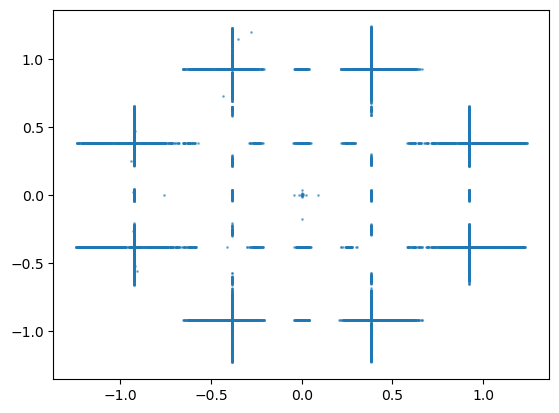

Fitting k=4...X shape = (10000, 2)
Fitting k=8...X shape = (10000, 2)
Fitting k=8...X shape = (10000, 2)
Fitting k=16...X shape = (10000, 2)
Fitting k=16...X shape = (10000, 2)
Fitting k=64...X shape = (10000, 2)
Fitting k=64...X shape = (10000, 2)


Processing files:  50%|█████     | 3/6 [00:12<00:12,  4.11s/it]

Shape: (10000, 2)
Best k based on silhouette score: 8
Silhouette scores: {4: '0.664', 8: '0.684', 16: '0.554', 64: '0.586'}
Loading 8cpsk_f70M_fs56M_s10k_snr0_fadingNone_x71.csv... 

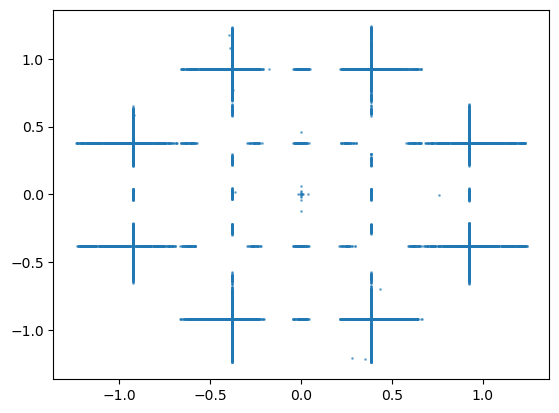

Fitting k=4...X shape = (10000, 2)
Fitting k=8...X shape = (10000, 2)
Fitting k=8...X shape = (10000, 2)
Fitting k=16...X shape = (10000, 2)
Fitting k=16...X shape = (10000, 2)
Fitting k=64...X shape = (10000, 2)
Fitting k=64...X shape = (10000, 2)


Processing files:  67%|██████▋   | 4/6 [00:16<00:08,  4.06s/it]

Shape: (10000, 2)
Best k based on silhouette score: 8
Silhouette scores: {4: '0.662', 8: '0.689', 16: '0.555', 64: '0.586'}
Loading 8cpsk_f70M_fs56M_s10k_snr30_fadingNone_x75.csv... 

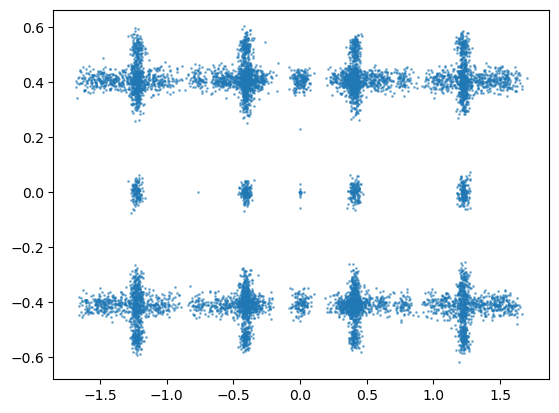

Fitting k=4...X shape = (10000, 2)
Fitting k=8...X shape = (10000, 2)
Fitting k=8...X shape = (10000, 2)
Fitting k=16...X shape = (10000, 2)
Fitting k=16...X shape = (10000, 2)
Fitting k=64...X shape = (10000, 2)
Fitting k=64...X shape = (10000, 2)


Processing files:  83%|████████▎ | 5/6 [00:20<00:04,  4.07s/it]

Shape: (10000, 2)
Best k based on silhouette score: 4
Silhouette scores: {4: '0.750', 8: '0.573', 16: '0.519', 64: '0.398'}
Loading 8cpsk_f70M_fs56M_s10k_snr30_fadingNone_x81.csv... 

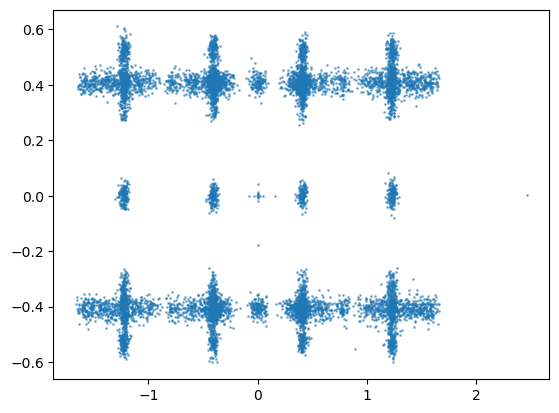

Fitting k=4...X shape = (10000, 2)
Fitting k=8...X shape = (10000, 2)
Fitting k=8...X shape = (10000, 2)
Fitting k=16...X shape = (10000, 2)
Fitting k=16...X shape = (10000, 2)
Fitting k=64...X shape = (10000, 2)
Fitting k=64...X shape = (10000, 2)


Processing files: 100%|██████████| 6/6 [00:24<00:00,  4.09s/it]

Shape: (10000, 2)
Best k based on silhouette score: 4
Silhouette scores: {4: '0.751', 8: '0.580', 16: '0.498', 64: '0.398'}


TypeError: cannot unpack non-iterable NoneType object

In [19]:
import pandas as pd
import pathlib
from tqdm import tqdm
import matplotlib.pyplot as plt

def load_and_process_directory(data_dir, frame_len=2048, hop_len=None, max_files=None):
    """
    Load all CSV files from directory and process them for clustering
    
    Parameters:
    - data_dir: Path to directory containing CSV files
    - frame_len: Frame length for slicing (default: 2048)
    - hop_len: Hop length for overlap (default: frame_len, no overlap)
    - max_files: Maximum number of files to process (None = all files)
    
    Returns:
    - X: Feature matrix ready for clustering
    - file_info: List of (filename, frame_indices) for tracking
    """
    
    data_path = pathlib.Path(data_dir)
    csv_files = sorted(list(data_path.glob('*.csv')))
    
    if max_files:
        csv_files = csv_files[:max_files]
    
    print(f"Found {len(csv_files)} CSV files in {data_dir}")
    
    all_features = []
    file_info = []
    
    for file_idx, csv_file in enumerate(tqdm(csv_files, desc="Processing files")):
        try:
            # Load CSV file (assuming it has I/Q data after metadata rows)
            print(f"Loading {csv_file.name}...", end=" ")
            
            # Skip first 10 rows (metadata) and load I/Q data
            df = pd.read_csv(csv_file, skiprows=10, names=['I', 'Q'])
            
            # Remove any non-numeric rows
            df = df.loc[~df['I'].isin(['TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame'])]
            df['I'] = df['I'].astype('float')
            df['Q'] = df['Q'].astype('float')
            
            # Convert to complex IQ signal
            iq_signal = np.vstack((df['I'].values, df['Q'].values)).reshape(-1, 2)
            idx = np.random.choice(iq_signal.shape[0], size=10000, replace=False)
            sampled = iq_signal[idx]   
            plt.plot(df['I'].values, df['Q'].values, 'o', markersize=1, alpha=0.5)
            plt.show()

            # Identify number of clusters
            ks = [4, 8, 16, 64]
            inertias, sils = sweep_k(sampled, ks)

            
            print(f"Shape: {iq_signal.shape}")
            best_k = ks[int(np.argmax(sils))]
            print(f"Best k based on silhouette score: {best_k}")
            print(f"Silhouette scores: {dict(zip(ks, [f'{s:.3f}' for s in sils]))}")
            
            
            
        except Exception as e:
            print(f"Error processing {csv_file.name}: {e}")
            continue


# Set your data directory path here
data_directory = "C:/Users/UserAdmin/Desktop/Jason - Signal Classification/AI Models/Data/synthetic/visual"

# Process all files in the directory
X_raw, file_info = load_and_process_directory(
    data_directory, 
    frame_len=20000, 
    hop_len=20000,  # No overlap
    max_files=None  # Process all files
)

In [170]:
import pandas as pd
import pathlib
from tqdm import tqdm

def load_and_process_directory(data_dir, frame_len=2048, hop_len=None, max_files=None):
    """
    Load all CSV files from directory and process them for clustering
    
    Parameters:
    - data_dir: Path to directory containing CSV files
    - frame_len: Frame length for slicing (default: 2048)
    - hop_len: Hop length for overlap (default: frame_len, no overlap)
    - max_files: Maximum number of files to process (None = all files)
    
    Returns:
    - X: Feature matrix ready for clustering
    - file_info: List of (filename, frame_indices) for tracking
    """
    
    data_path = pathlib.Path(data_dir)
    csv_files = sorted(list(data_path.glob('*.csv')))
    
    if max_files:
        csv_files = csv_files[:max_files]
    
    print(f"Found {len(csv_files)} CSV files in {data_dir}")
    
    all_features = []
    file_info = []
    
    for file_idx, csv_file in enumerate(tqdm(csv_files, desc="Processing files")):
        try:
            # Load CSV file (assuming it has I/Q data after metadata rows)
            print(f"Loading {csv_file.name}...", end=" ")
            
            # Skip first 10 rows (metadata) and load I/Q data
            df = pd.read_csv(csv_file, skiprows=10, names=['I', 'Q'])
            
            # Remove any non-numeric rows
            df = df.loc[~df['I'].isin(['TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame'])]
            df['I'] = df['I'].astype('float')
            df['Q'] = df['Q'].astype('float')
            
            # Convert to complex IQ signal
            iq_signal = np.vstack((df['I'].values, df['Q'].values)).reshape(-1, 2)
            
            print(f"Shape: {iq_signal.shape}")
            
            # Slice into frames
            frames = slice_iq(iq_signal, frame_len=frame_len, hop_len=hop_len)
            print(f"  -> {frames.shape[0]} frames")
            
            # Normalize frames
            frames_norm = rms_norm(frames)
            
            # Extract FFT features
            features = log_mag_fft(frames_norm)
            features = frames_norm
            
            # Store features and track which file they came from
            all_features.append(features)
            
            # Track file info for each frame
            for frame_idx in range(features.shape[0]):
                file_info.append({
                    'file_name': csv_file.name,
                    'file_index': file_idx,
                    'frame_index': frame_idx,
                    'total_frames': features.shape[0]
                })
            
        except Exception as e:
            print(f"Error processing {csv_file.name}: {e}")
            continue
    
    # Combine all features
    if all_features:
        X = np.vstack(all_features)
        print(f"\nTotal features shape: {X.shape}")
        print(f"Total frames from {len(csv_files)} files: {len(file_info)}")
        return X, file_info
    else:
        print("No features extracted!")
        return None, None

# Set your data directory path here
data_directory = "C:/Users/UserAdmin/Desktop/Jason - Signal Classification/AI Models/Data/synthetic/synthetic_set0"

# Process all files in the directory
X_raw, file_info = load_and_process_directory(
    data_directory, 
    frame_len=20000, 
    hop_len=20000,  # No overlap
    max_files=None  # Process all files
)

Found 30 CSV files in C:/Users/UserAdmin/Desktop/Jason - Signal Classification/AI Models/Data/synthetic/synthetic_set0


Processing files:   7%|▋         | 2/30 [00:00<00:01, 14.99it/s]

Loading 16qam_f70M_s200k_syn_x1.csv... Shape: (200000, 2)
  -> 10 frames
Loading 16qam_f70M_s200k_syn_x10.csv... Shape: (200000, 2)
  -> 10 frames
Loading 16qam_f70M_s200k_syn_x2.csv... Shape: (200000, 2)
  -> 10 frames
Loading 16qam_f70M_s200k_syn_x3.csv... 

Processing files:  20%|██        | 6/30 [00:00<00:01, 15.02it/s]

Shape: (200000, 2)
  -> 10 frames
Loading 16qam_f70M_s200k_syn_x4.csv... Shape: (200000, 2)
  -> 10 frames
Loading 16qam_f70M_s200k_syn_x5.csv... Shape: (200000, 2)
  -> 10 frames
Loading 16qam_f70M_s200k_syn_x6.csv... Shape: (200000, 2)
  -> 10 frames
Loading 16qam_f70M_s200k_syn_x7.csv... 

Processing files:  33%|███▎      | 10/30 [00:00<00:01, 15.67it/s]

Shape: (200000, 2)
  -> 10 frames
Loading 16qam_f70M_s200k_syn_x8.csv... Shape: (200000, 2)
  -> 10 frames
Loading 16qam_f70M_s200k_syn_x9.csv... Shape: (200000, 2)
  -> 10 frames
Loading 8cpsk_f70M_s200k_syn_x1.csv... Shape: (200000, 2)
  -> 10 frames
Loading 8cpsk_f70M_s200k_syn_x10.csv... 

Processing files:  47%|████▋     | 14/30 [00:00<00:01, 14.59it/s]

Shape: (200000, 2)
  -> 10 frames
Loading 8cpsk_f70M_s200k_syn_x2.csv... Shape: (200000, 2)
  -> 10 frames
Loading 8cpsk_f70M_s200k_syn_x3.csv... Shape: (200000, 2)
  -> 10 frames
Loading 8cpsk_f70M_s200k_syn_x4.csv... 

Processing files:  53%|█████▎    | 16/30 [00:01<00:00, 14.04it/s]

Shape: (200000, 2)
  -> 10 frames
Loading 8cpsk_f70M_s200k_syn_x5.csv... Shape: (200000, 2)
  -> 10 frames
Loading 8cpsk_f70M_s200k_syn_x6.csv... Shape: (200000, 2)
  -> 10 frames
Loading 8cpsk_f70M_s200k_syn_x7.csv... 

Processing files:  67%|██████▋   | 20/30 [00:01<00:00, 14.47it/s]

Shape: (200000, 2)
  -> 10 frames
Loading 8cpsk_f70M_s200k_syn_x8.csv... Shape: (200000, 2)
  -> 10 frames
Loading 8cpsk_f70M_s200k_syn_x9.csv... Shape: (200000, 2)
  -> 10 frames
Loading fm_f70M_s200k_syn_x1.csv... 

Processing files:  80%|████████  | 24/30 [00:01<00:00, 15.04it/s]

Shape: (200000, 2)
  -> 10 frames
Loading fm_f70M_s200k_syn_x10.csv... Shape: (200000, 2)
  -> 10 frames
Loading fm_f70M_s200k_syn_x2.csv... Shape: (200000, 2)
  -> 10 frames
Loading fm_f70M_s200k_syn_x3.csv... Shape: (200000, 2)
  -> 10 frames


Processing files:  87%|████████▋ | 26/30 [00:01<00:00, 14.91it/s]

Loading fm_f70M_s200k_syn_x4.csv... Shape: (200000, 2)
  -> 10 frames
Loading fm_f70M_s200k_syn_x5.csv... Shape: (200000, 2)
  -> 10 frames
Loading fm_f70M_s200k_syn_x6.csv... 

Processing files:  93%|█████████▎| 28/30 [00:01<00:00, 15.06it/s]

Shape: (200000, 2)
  -> 10 frames
Loading fm_f70M_s200k_syn_x7.csv... Shape: (200000, 2)
  -> 10 frames
Loading fm_f70M_s200k_syn_x8.csv... Shape: (200000, 2)
  -> 10 frames
Loading fm_f70M_s200k_syn_x9.csv... 

Processing files: 100%|██████████| 30/30 [00:02<00:00, 14.74it/s]

Shape: (200000, 2)
  -> 10 frames

Total features shape: (300, 20000)
Total frames from 30 files: 300


In [171]:
X_raw.shape

(300, 20000)

In [178]:
# Preprocess the features for clustering
if X_raw is not None:
    print("Preprocessing features...")
    Xz, scaler, pca = preprocess(X_raw, pca_energy=0.95)
    
    print(f"Original features shape: {X_raw.shape}")
    print(f"After preprocessing: {Xz.shape}")
    if pca is not None:
        print(f"PCA explained variance ratio: {pca.explained_variance_ratio_.sum():.3f}")
        print(f"Number of components: {pca.n_components_}")
    
    # Show some statistics about the data
    file_counts = {}
    for info in file_info:
        file_name = info['file_name']
        if file_name not in file_counts:
            file_counts[file_name] = 0
        file_counts[file_name] += 1
    
    print(f"\nFrames per file:")
    for file_name, count in file_counts.items():
        print(f"  {file_name}: {count} frames")
else:
    print("No data loaded. Please check your directory path and file format.")

Preprocessing features...
Original features shape: (300, 20000)
After preprocessing: (300, 278)
PCA explained variance ratio: 0.952
Number of components: 278

Frames per file:
  16qam_f70M_s200k_syn_x1.csv: 10 frames
  16qam_f70M_s200k_syn_x10.csv: 10 frames
  16qam_f70M_s200k_syn_x2.csv: 10 frames
  16qam_f70M_s200k_syn_x3.csv: 10 frames
  16qam_f70M_s200k_syn_x4.csv: 10 frames
  16qam_f70M_s200k_syn_x5.csv: 10 frames
  16qam_f70M_s200k_syn_x6.csv: 10 frames
  16qam_f70M_s200k_syn_x7.csv: 10 frames
  16qam_f70M_s200k_syn_x8.csv: 10 frames
  16qam_f70M_s200k_syn_x9.csv: 10 frames
  8cpsk_f70M_s200k_syn_x1.csv: 10 frames
  8cpsk_f70M_s200k_syn_x10.csv: 10 frames
  8cpsk_f70M_s200k_syn_x2.csv: 10 frames
  8cpsk_f70M_s200k_syn_x3.csv: 10 frames
  8cpsk_f70M_s200k_syn_x4.csv: 10 frames
  8cpsk_f70M_s200k_syn_x5.csv: 10 frames
  8cpsk_f70M_s200k_syn_x6.csv: 10 frames
  8cpsk_f70M_s200k_syn_x7.csv: 10 frames
  8cpsk_f70M_s200k_syn_x8.csv: 10 frames
  8cpsk_f70M_s200k_syn_x9.csv: 10 frames
  

## Clustering

Running K-means clustering analysis...


c:\Users\UserAdmin\miniconda3\envs\new_tf_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\UserAdmin\miniconda3\envs\new_tf_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\UserAdmin\miniconda3\envs\new_tf_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\UserAdmin\miniconda3\envs\new_tf_env\lib\site-packages\sklearn\c

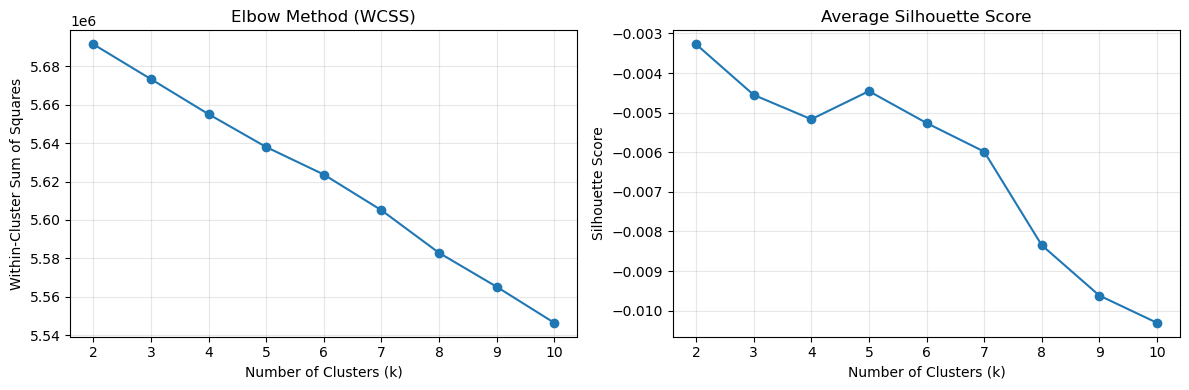

Best k based on silhouette score: 2
Silhouette scores: {2: '-0.003', 3: '-0.005', 4: '-0.005', 5: '-0.004', 6: '-0.005', 7: '-0.006', 8: '-0.008', 9: '-0.010', 10: '-0.010'}


In [179]:
import matplotlib.pyplot as plt

# Only run clustering if we have data
print("Running K-means clustering analysis...")
    
ks = range(2, 11)
inertias, sils = sweep_k(Xz, ks)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(ks, inertias, "o-")
ax[0].set_title("Elbow Method (WCSS)")
ax[0].set_xlabel("Number of Clusters (k)")
ax[0].set_ylabel("Within-Cluster Sum of Squares")
ax[0].grid(True, alpha=0.3)

ax[1].plot(ks, sils, "o-")
ax[1].set_title("Average Silhouette Score")
ax[1].set_xlabel("Number of Clusters (k)")
ax[1].set_ylabel("Silhouette Score")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

best_k = ks[int(np.argmax(sils))]
print(f"Best k based on silhouette score: {best_k}")
print(f"Silhouette scores: {dict(zip(ks, [f'{s:.3f}' for s in sils]))}")



In [175]:
# Perform final clustering with best k

print(f"Performing final clustering with k={best_k}...")

km = KMeans(n_clusters=best_k, random_state=0, n_init="auto").fit(Xz)
labels = km.labels_
centroids = km.cluster_centers_

print(f"Clustering completed!")
print(f"Cluster assignments:")
unique_labels, counts = np.unique(labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    percentage = count / len(labels) * 100
    print(f"  Cluster {label}: {count} frames ({percentage:.1f}%)")

# Analyze cluster assignments by file
print(f"\nCluster distribution by file:")
cluster_by_file = {}
for i, info in enumerate(file_info):
    file_name = info['file_name']
    cluster = labels[i]
    
    if file_name not in cluster_by_file:
        cluster_by_file[file_name] = {}
    if cluster not in cluster_by_file[file_name]:
        cluster_by_file[file_name][cluster] = 0
    cluster_by_file[file_name][cluster] += 1

for file_name, clusters in cluster_by_file.items():
    total_frames = sum(clusters.values())
    print(f"\n  {file_name} ({total_frames} frames):")
    for cluster in sorted(clusters.keys()):
        count = clusters[cluster]
        percentage = count / total_frames * 100
        print(f"    Cluster {cluster}: {count} frames ({percentage:.1f}%)")


Performing final clustering with k=2...
Clustering completed!
Cluster assignments:
  Cluster 0: 49 frames (16.3%)
  Cluster 1: 251 frames (83.7%)

Cluster distribution by file:

  16qam_f70M_s200k_syn_x1.csv (10 frames):
    Cluster 0: 3 frames (30.0%)
    Cluster 1: 7 frames (70.0%)

  16qam_f70M_s200k_syn_x10.csv (10 frames):
    Cluster 0: 4 frames (40.0%)
    Cluster 1: 6 frames (60.0%)

  16qam_f70M_s200k_syn_x2.csv (10 frames):
    Cluster 0: 2 frames (20.0%)
    Cluster 1: 8 frames (80.0%)

  16qam_f70M_s200k_syn_x3.csv (10 frames):
    Cluster 0: 4 frames (40.0%)
    Cluster 1: 6 frames (60.0%)

  16qam_f70M_s200k_syn_x4.csv (10 frames):
    Cluster 0: 2 frames (20.0%)
    Cluster 1: 8 frames (80.0%)

  16qam_f70M_s200k_syn_x5.csv (10 frames):
    Cluster 0: 3 frames (30.0%)
    Cluster 1: 7 frames (70.0%)

  16qam_f70M_s200k_syn_x6.csv (10 frames):
    Cluster 0: 5 frames (50.0%)
    Cluster 1: 5 frames (50.0%)

  16qam_f70M_s200k_syn_x7.csv (10 frames):
    Cluster 0: 1 frame

c:\Users\UserAdmin\miniconda3\envs\new_tf_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Creating UMAP visualization...


c:\Users\UserAdmin\miniconda3\envs\new_tf_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


File index legend:
  Index 0: 16qam_f70M_s200k_syn_x1.csv
  Index 1: 16qam_f70M_s200k_syn_x10.csv
  Index 2: 16qam_f70M_s200k_syn_x2.csv
  Index 3: 16qam_f70M_s200k_syn_x3.csv
  Index 4: 16qam_f70M_s200k_syn_x4.csv
  Index 5: 16qam_f70M_s200k_syn_x5.csv
  Index 6: 16qam_f70M_s200k_syn_x6.csv
  Index 7: 16qam_f70M_s200k_syn_x7.csv
  Index 8: 16qam_f70M_s200k_syn_x8.csv
  Index 9: 16qam_f70M_s200k_syn_x9.csv
  Index 10: 8cpsk_f70M_s200k_syn_x1.csv
  Index 11: 8cpsk_f70M_s200k_syn_x10.csv
  Index 12: 8cpsk_f70M_s200k_syn_x2.csv
  Index 13: 8cpsk_f70M_s200k_syn_x3.csv
  Index 14: 8cpsk_f70M_s200k_syn_x4.csv
  Index 15: 8cpsk_f70M_s200k_syn_x5.csv
  Index 16: 8cpsk_f70M_s200k_syn_x6.csv
  Index 17: 8cpsk_f70M_s200k_syn_x7.csv
  Index 18: 8cpsk_f70M_s200k_syn_x8.csv
  Index 19: 8cpsk_f70M_s200k_syn_x9.csv
  Index 20: fm_f70M_s200k_syn_x1.csv
  Index 21: fm_f70M_s200k_syn_x10.csv
  Index 22: fm_f70M_s200k_syn_x2.csv
  Index 23: fm_f70M_s200k_syn_x3.csv
  Index 24: fm_f70M_s200k_syn_x4.csv
  I

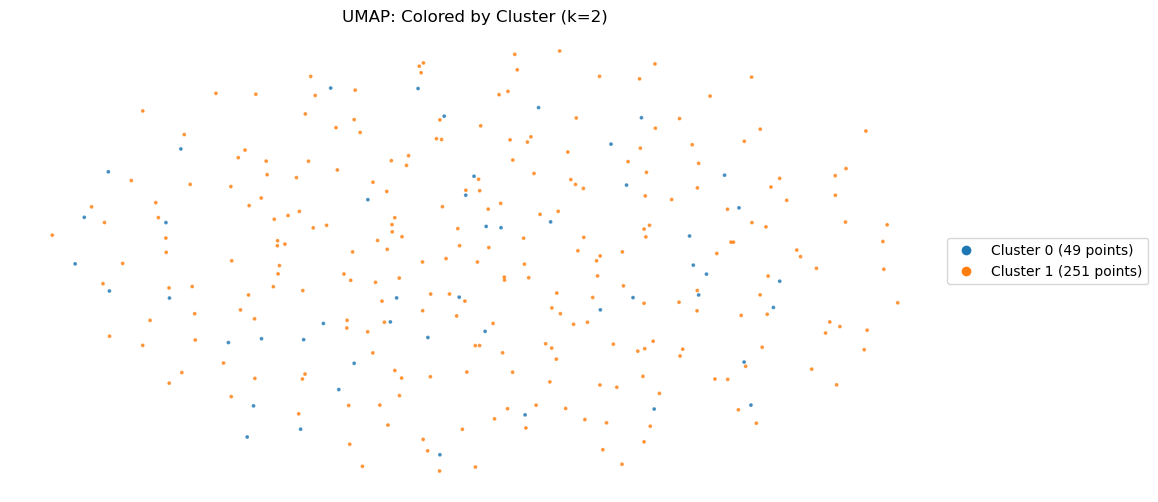

In [176]:
import umap

# Create UMAP visualization if clustering is complete
print("Creating UMAP visualization...")

embedding = umap.UMAP(n_neighbors=50, min_dist=0.1, metric="euclidean",
                        random_state=0).fit_transform(Xz)

# Create two visualizations: one colored by cluster, one by file
plt.figure(figsize=(12, 6))

# Plot 1: Color by cluster
colors = plt.cm.tab10(labels)  # Use tab10 colormap for distinct colors
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=3, alpha=0.7)
plt.title(f"UMAP: Colored by Cluster (k={best_k})")
plt.axis("off")
# Create custom legend for clusters
unique_labels = np.unique(labels)
legend_elements = []
for label in unique_labels:
    color = plt.cm.tab10(label)
    count = np.sum(labels == label)
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                    markerfacecolor=color, markersize=8, 
                                    label=f'Cluster {label} ({count} points)'))
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

# Print legend for file indices
print("File index legend:")
unique_files = {}
for info in file_info:
    unique_files[info['file_index']] = info['file_name']

for idx in sorted(unique_files.keys()):
    print(f"  Index {idx}: {unique_files[idx]}")
        

In [177]:
import joblib, pathlib, json

# Save the clustering model and results if everything is complete
print("Saving clustering model and results...")

pathlib.Path("models").mkdir(exist_ok=True)

# Save the trained models
model_data = {
    "scaler": scaler, 
    "pca": pca, 
    "kmeans": km,
    "best_k": best_k,
    "feature_shape": X_raw.shape,
    "processed_shape": Xz.shape
}
joblib.dump(model_data, "models/clustering_model.pkl")

# Save metadata
meta_data = {
    "frame_len": 2048, 
    "hop_len": 2048,
    "pca_components": pca.n_components_ if pca else None,
    "pca_variance_explained": float(pca.explained_variance_ratio_.sum()) if pca else None,
    "num_clusters": best_k,
    "total_frames": len(labels),
    "files_processed": len(set(info['file_name'] for info in file_info))
}
json.dump(meta_data, open("models/clustering_meta.json", "w"), indent=2)

# Save detailed results
results_data = {
    "file_info": file_info,
    "cluster_labels": labels.tolist(),
    "cluster_counts": {int(k): int(v) for k, v in zip(*np.unique(labels, return_counts=True))}
}
json.dump(results_data, open("models/clustering_results.json", "w"), indent=2)

print(f"✓ Saved clustering model to: models/clustering_model.pkl")
print(f"✓ Saved metadata to: models/clustering_meta.json") 
print(f"✓ Saved results to: models/clustering_results.json")
print(f"✓ Processed {len(set(info['file_name'] for info in file_info))} files")
print(f"✓ Generated {len(labels)} feature vectors")
print(f"✓ Found {best_k} optimal clusters")


Saving clustering model and results...


TypeError: Object of type int64 is not JSON serializable